In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 12, repr.plot.height = 12) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Read the zip file from url and unzip so it can be loaded into a dataframe
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
zip_file <- tempfile(fileext = ".zip")
download.file(url, zip_file, mode = "wb")
student_data <- read_delim(unz(description = zip_file, filename = "student-mat.csv"), delim = ";")

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [68]:
# Grouped the Final Grade into intervals for easier labelling down the line
# Grades 0-5 is 1, 6-10 is 2, 11-15 is 3 and 16-20 is 4

student_data_group <- student_data %>%
    mutate(label = cut(G3, c(0, 9, 11, 13, 15, 20), 
                       #labels = c("fail", "sufficient", "satisfactory", "good", "excellent"), 
                       labels = c(1, 2, 3, 4, 5),
                       left = FALSE)) %>%
    #group_by(label = unlist(label)) %>%
    group_by(label = as.factor(label)) %>%
    filter(!is.na(label)) #%>%
    #str(label)

student_data_group

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,3,4,1,1,3,6,5,6,6,1
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,3,3,1,1,3,4,5,5,6,1
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,3,2,2,3,3,10,7,8,10,2
GP,F,15,U,GT3,T,4,2,health,services,⋯,2,2,1,1,5,2,15,14,15,4
GP,F,16,U,GT3,T,3,3,other,other,⋯,3,2,1,2,5,4,6,10,10,2
GP,M,16,U,LE3,T,4,3,services,other,⋯,4,2,1,2,5,10,15,15,15,4
GP,M,16,U,LE3,T,2,2,other,other,⋯,4,4,1,1,3,0,12,12,11,2
GP,F,17,U,GT3,A,4,4,other,teacher,⋯,1,4,1,1,1,6,6,5,6,1
GP,M,15,U,LE3,A,3,2,services,other,⋯,2,2,1,1,1,0,16,18,19,5


In [75]:
length(cut(student_data$G3, c(0, 9, 11, 13, 15, 20),labels = c(1, 2, 3, 4, 5)))


[1] 395

In [20]:
# Converted the binary predictors from (yes, no) to (1,0)
student_data_cleaned_binary <- student_data_group %>%
    mutate(school = recode(school, 
                     "GP" = "0",   # for school, GP value is 0, MS value is 1
                     "MS" = "1"))  %>% 
    mutate(school = as.numeric(school)) %>%
    mutate(sex = recode(sex,
                       "M" = "0",  # for sex, male is 0, female is 1
                       "F" = "1")) %>%
    mutate(sex = as.numeric(sex)) %>%
    mutate(address = recode(address,
                           "U" = "0",   # for address, urban is 0, rural is 1
                           "R" = "1")) %>%
    mutate(address = as.numeric(address)) %>%
    mutate(famsize = recode(famsize,
                           "LE3" = "0",  # for family size, less than or equal to 3 is 0, greater than 3 is 1
                           "GT3" = "1")) %>%
    mutate(famsize = as.numeric(famsize)) %>%
    mutate(Pstatus = recode(Pstatus,
                           "T" = "0",    # for parental cohabitation status, together is 0, apart is 1
                           "A" = "1")) %>%
    mutate(Pstatus = as.numeric(Pstatus)) %>%
    mutate(schoolsup = recode(schoolsup,
                             "no" = "0", # for extra education support at school, no is 0, yes is 1
                             "yes" = "1")) %>%
    mutate(schoolsup = as.numeric(schoolsup)) %>%
    mutate(famsup = recode(famsup,
                          "no" = "0",    # for extra educatino support at home, no is 0, yes is 1
                          "yes" = "1")) %>%
    mutate(famsup = as.numeric(famsup)) %>%
    mutate(paid = recode(paid,
                          "no" = "0",    # for extra paid educatino support (tutor) , no is 0, yes is 1
                          "yes" = "1")) %>%
    mutate(paid = as.numeric(paid)) %>%
    mutate(activities = recode(activities,
                          "no" = "0",    # for extracurricular activities, no is 0, yes is 1
                          "yes" = "1")) %>%
    mutate(activities= as.numeric(activities)) %>%
    mutate(nursery = recode(nursery,
                          "no" = "0",    # for if they attended nursery school (preschool/kindergarten, no is 0, yes is 1
                          "yes" = "1")) %>%
    mutate(nursery = as.numeric(nursery)) %>%
    mutate(higher = recode(higher,
                          "no" = "0",    # for if they aspire for higher education, no is 0, yes is 1
                          "yes" = "1")) %>%
    mutate(higher = as.numeric(higher)) %>%
    mutate(internet = recode(internet,
                          "no" = "0",    # for internet access at home, no is 0, yes is 1
                          "yes" = "1")) %>%
    mutate(internet = as.numeric(internet)) %>%
    mutate(romantic = recode(romantic,
                          "no" = "0",    # for being in a romantic relationship, no is 0, yes is 1
                          "yes" = "1")) %>%
    mutate(romantic= as.numeric(romantic)) 


In [69]:
# Split the data into training and testing set
#student_data_split <- initial_split(student_data_cleaned_binary, prop = 0.75, strata = label)
student_data_split <- initial_split(student_data_group, prop = 0.75, strata = label)
student_train <- training(student_data_split)
student_test <- testing(student_data_split)

In [22]:
# Exploratory Data Analysis
# Distribution of mother's education level
student_train_meduc <- group_by(student_train, Medu) %>%
    summarize(n = n())

# Distribution of father's education level
student_train_feduc <- group_by(student_train, Fedu) %>%
    summarize(n = n())

# Counts number of student failures
student_train_failure <- group_by(student_train, failures) %>%
    summarize(n=n())

# Counts number of student absences
student_train_absences <- group_by(student_train, absences) %>%
    summarize(n=n())

# Computes mean of student absences
student_train_absences_m <- group_by(student_train) %>%
    summarize(absences_m = mean(absences))

# Computes mean family relationship quality
student_train_famrel <- group_by(student_train) %>%
    summarize(famrel = mean(famrel))

# Computes mean overall health status
student_train_health <- group_by(student_train) %>%
    summarize(health = mean(health))

# Computes mean student travel time
student_train_travel <- group_by(student_train) %>%
    summarize(traveltime = mean(traveltime))

# Student final grade distribution
student_train_G3 <- group_by(student_train, G3) %>%
    summarize(n = n())

student_train_meduc
student_train_feduc
student_train_failure
student_train_absences
student_train_absences_m
student_train_famrel
student_train_health
student_train_travel
student_train_G3

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Medu,n
<dbl>,<int>
0,2
1,41
2,64
3,68
4,93


Fedu,n
<dbl>,<int>
0,1
1,57
2,73
3,70
4,67


failures,n
<dbl>,<int>
0,218
1,34
2,9
3,7


absences,n
<dbl>,<int>
0,61
1,3
2,48
3,7
4,38
5,3
6,23
7,5
8,18


absences_m
<dbl>
6.302239


famrel
<dbl>
3.947761


health
<dbl>
3.563433


traveltime
<dbl>
1.451493


G3,n
<dbl>,<int>
5,6
6,11
7,7
8,24
9,21
10,43
11,36
12,22
13,26


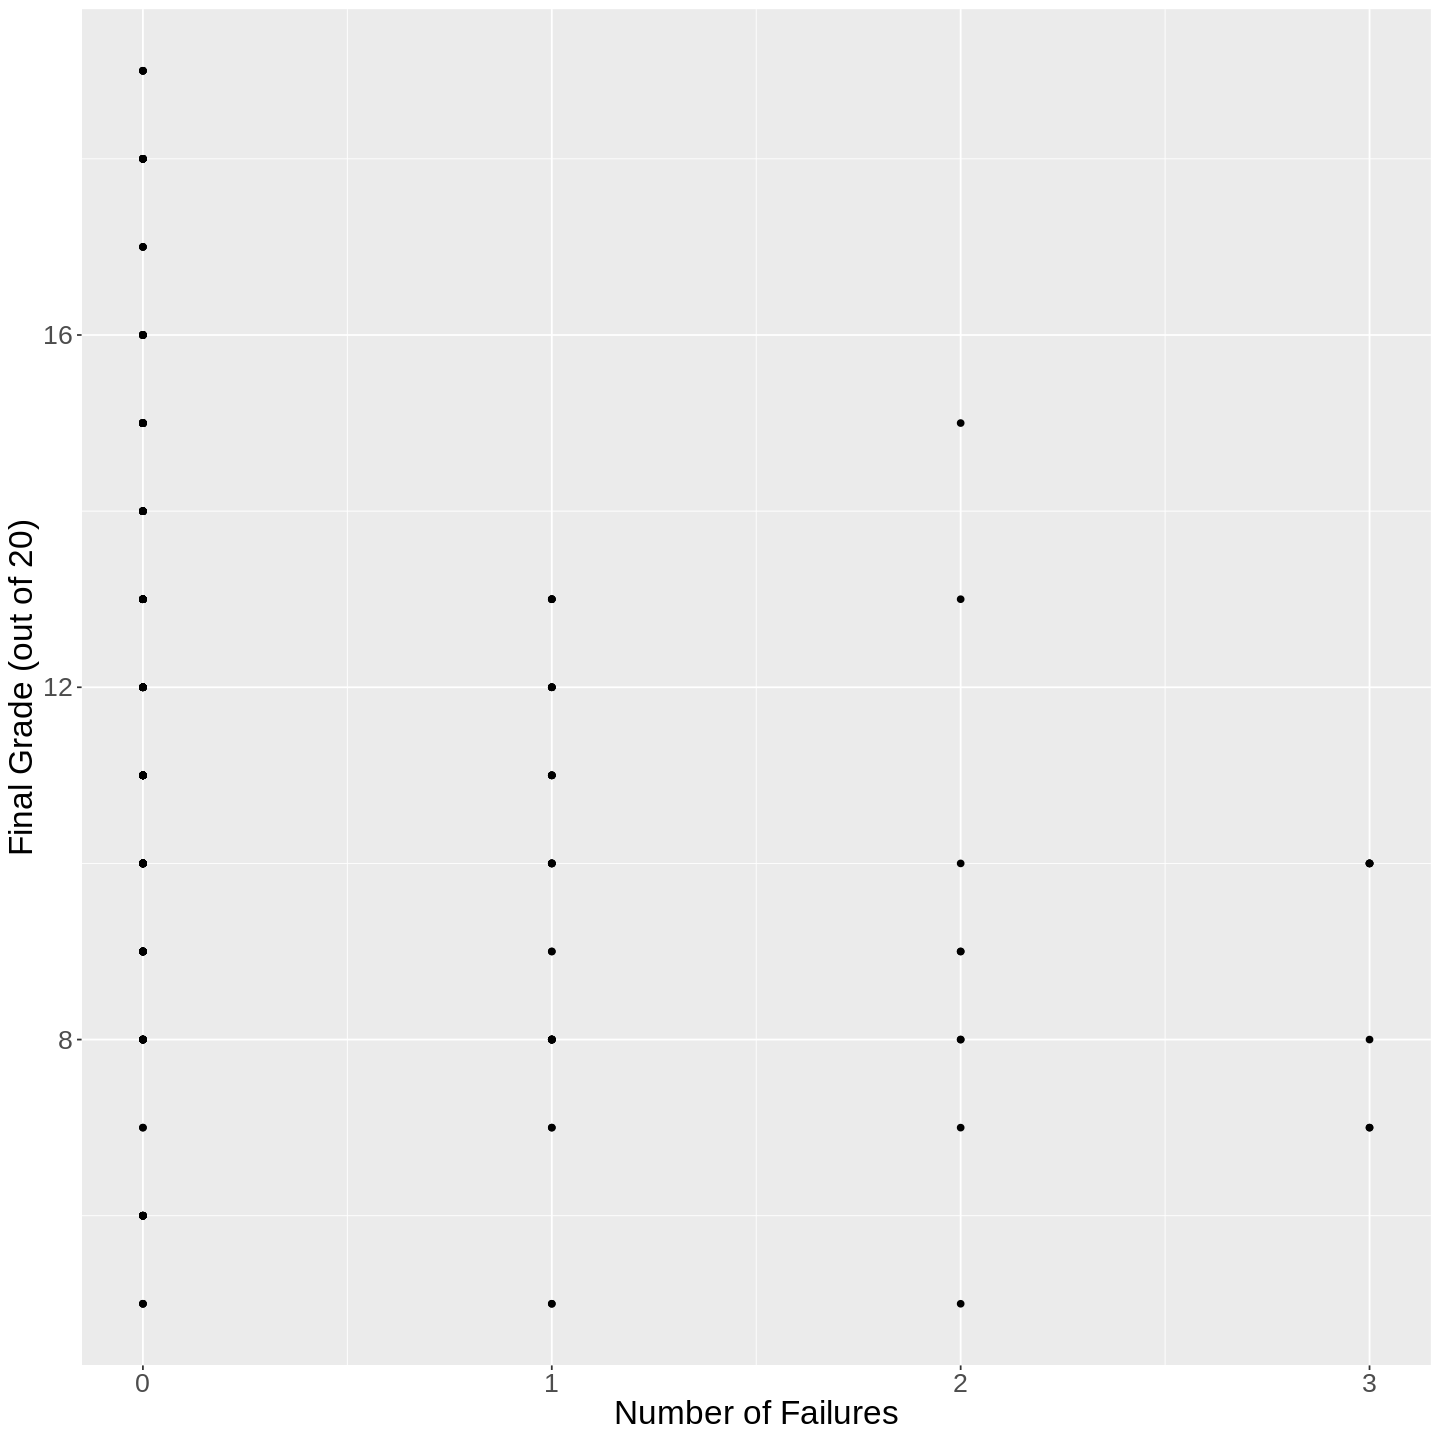

In [23]:
# Exploratory plot of Final Grade vs Number of Failures
student_plot <- ggplot(student_train, aes(x = failures, y = G3)) +
    geom_point() +
    labs(x = "Number of Failures" , y = "Final Grade (out of 20)") +
    theme(text = element_text(size = 20))
student_plot

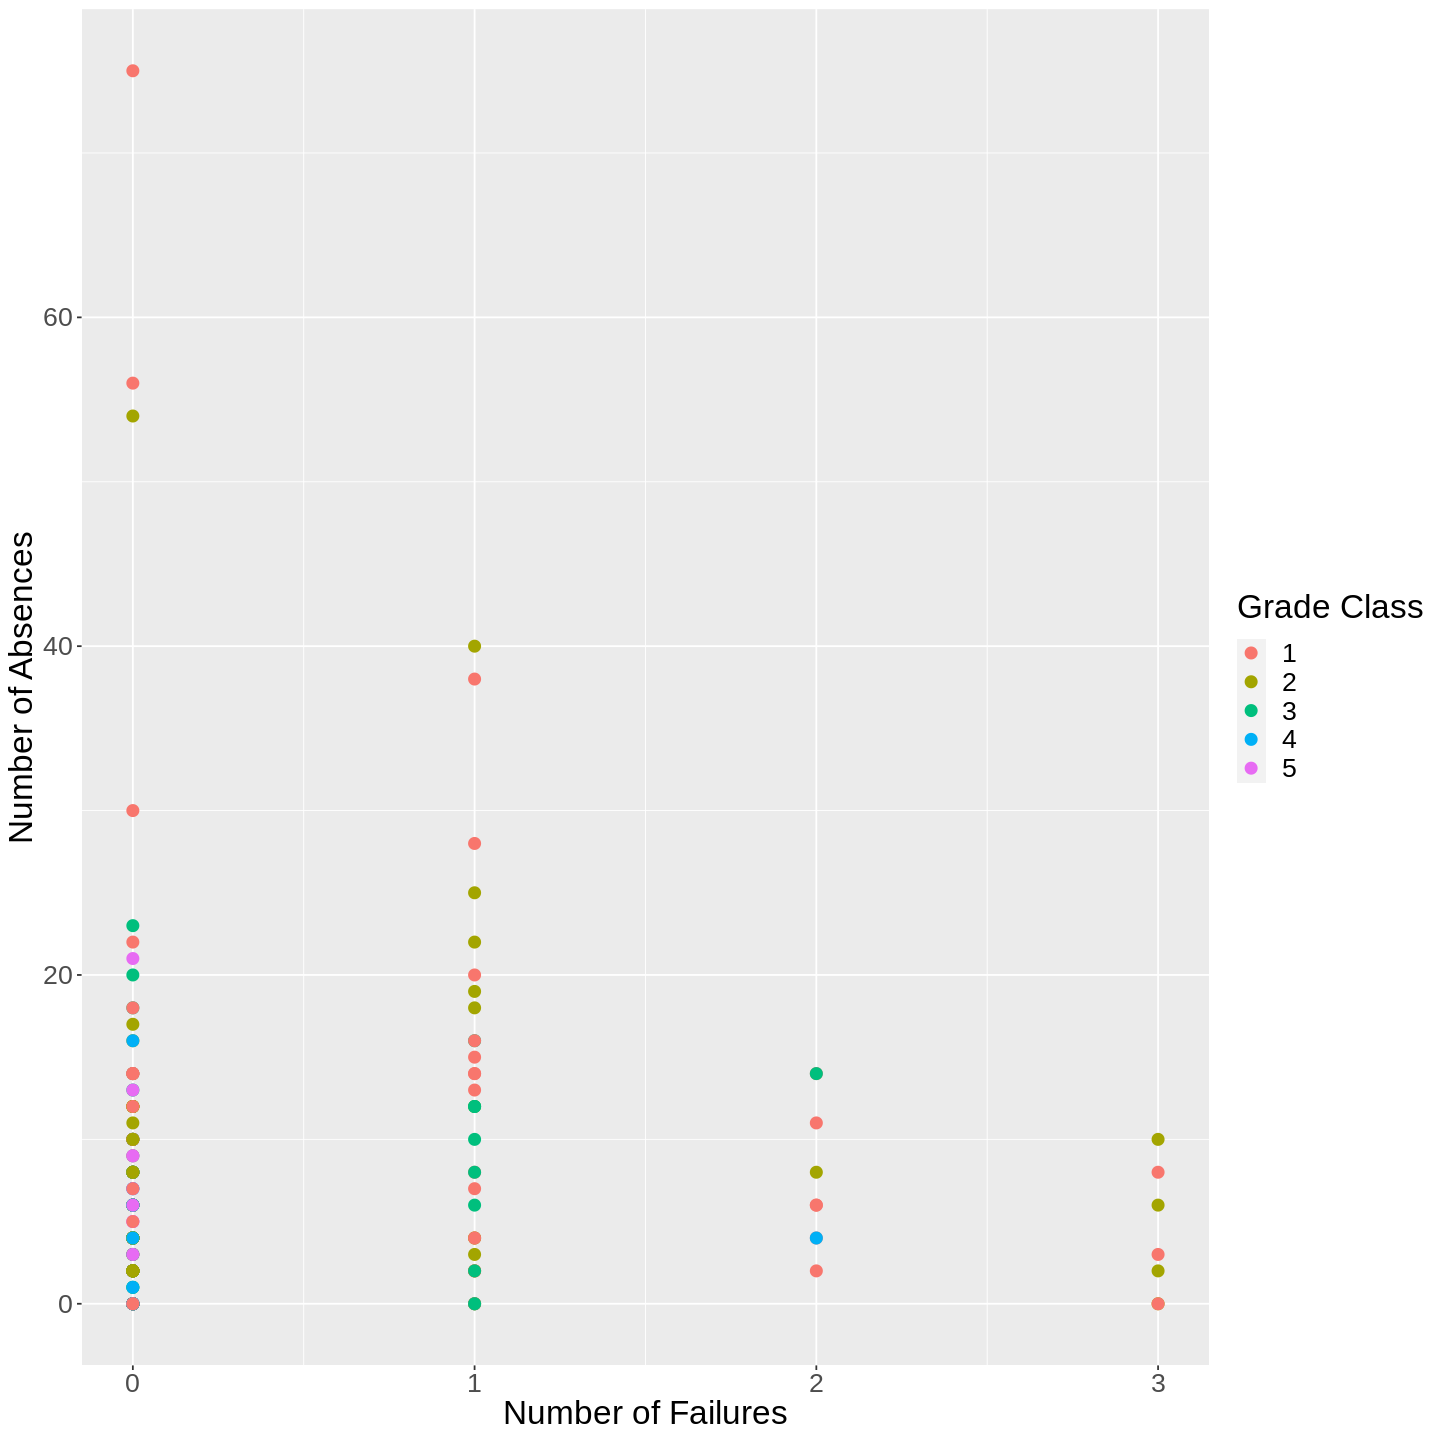

In [24]:
# Exporatory plot of Number of Absences vs Number of Failure with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = failures, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Number of Failures" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot2

In [77]:
# model specification

set.seed(2020)

student_recipe <- recipe(label ~ Medu + Fedu + traveltime + studytime + failures + famrel + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")
    
student_vfold <- vfold_cv(student_train, v = 5, strata = label)

# fixed version
knn_fit <- workflow() %>%
     add_recipe(student_recipe) %>%
     add_model(knn_spec) %>%
    tune_grid(resamples = student_vfold) %>%
    collect_metrics()

# initial version with very sad bug
knn_fit <- workflow() %>%
     add_recipe(student_recipe) %>%
     add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold) %>%
    collect_metrics()

knn_fit




neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2051898,5,0.022105298,Model01
1,roc_auc,hand_till,0.4935012,5,0.011720967,Model01
3,accuracy,multiclass,0.2489608,5,0.015424384,Model02
3,roc_auc,hand_till,0.5319638,5,0.017737367,Model02
5,accuracy,multiclass,0.2637807,5,0.019692147,Model03
5,roc_auc,hand_till,0.5240197,5,0.010887352,Model03
6,accuracy,multiclass,0.2638481,5,0.013955697,Model04
6,roc_auc,hand_till,0.5262508,5,0.009794791,Model04
8,accuracy,multiclass,0.2304916,5,0.012380565,Model05


In [71]:
head(student_train)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,3,4,1,1,3,6,5,6,6,1
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,3,2,2,3,3,10,7,8,10,2
GP,F,16,U,GT3,T,3,3,other,other,⋯,3,2,1,2,5,4,6,10,10,2
GP,M,16,U,LE3,T,4,3,services,other,⋯,4,2,1,2,5,10,15,15,15,4
GP,M,16,U,LE3,T,2,2,other,other,⋯,4,4,1,1,3,0,12,12,11,2
GP,M,15,U,GT3,T,3,4,other,other,⋯,5,1,1,1,5,0,14,15,15,4
